In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
!pip install ucimlrepo


from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder,StandardScaler
import numpy as np


Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Caminho absoluto para a pasta src
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
src_path_2 = os.path.abspath(os.path.join(os.getcwd(), '..', 'src/modelos'))
sys.path.append(src_path)
sys.path.append(src_path_2)

from model_wizard import buscar_melhor_wisard
from model_mlp import busca_melhores_mlp
from tratamento_dados import preprocess_numeric_data_wizard,preprocess_data_standart_scale
from metricas import plot_confusion_matrix, classification_metrics
from smote import SmoteTransformer

## Terceiro Dataset

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 

print ("Targets:")
print(y[y.columns[0]].unique())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

### Visualização de datasets

In [5]:
print("Features:")
print(X.head())
print("\nTargets:")
print(y)

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

Targets:
     num
0      0
1      2
2      1
3      0
4      0
..   ...
298    1
299    2
300    3
301    1
302    0

[303 rows x 1 columns]

Colunas categóricas: []
Colunas numéricas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


### Tratamento de Dados

In [18]:
# Inicializa o SMOTE transformer
smote_transformer = SmoteTransformer(random_state=42)

# Aplica SMOTE
X, y = smote_transformer.fit_transform(X, y)

# Mostra as dimensões após SMOTE
print("\nTamanho do conjunto após SMOTE:", X.shape)
print("Tamanho dos rótulos  após SMOTE:", y.shape)


Tamanho do conjunto após SMOTE: (800, 13)
Tamanho dos rótulos  após SMOTE: (800, 1)


In [19]:
# Converta X_train em DataFrame se estiver em array
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
else:
    X= X.copy()
    
# Remove linhas com NaN antes do processamento
X_clean = X.dropna(subset=numeric_cols)
y_clean = y.loc[X_clean.index]

# Processa os dados
X_processed, y_encoded, le = preprocess_numeric_data_wizard(X_clean, y_clean, numeric_cols)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])


Tamanho do conjunto de treino: (560, 104)
Tamanho do conjunto de teste: (240, 104)
Tamanho dos rótulos de treino: (560,)
Tamanho dos rótulos de teste: (240,)

Exemplo de X_train (primeiras 5 linhas):
[[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0
  0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0
  1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
  1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
 [1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0

#### Métricas

In [20]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Acurácia média na CV:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

Melhores parâmetros encontrados: {'wisard__tuple_size': 11, 'wisard__bleaching': False}
Acurácia média na CV: 0.6017671975926245
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       112
           1       0.74      0.82      0.78       112
           2       0.81      0.90      0.86       112
           3       0.87      0.79      0.83       112
           4       1.00      0.65      0.79       112

    accuracy                           0.83       560
   macro avg       0.85      0.83      0.83       560
weighted avg       0.85      0.83      0.83       560



### Predição

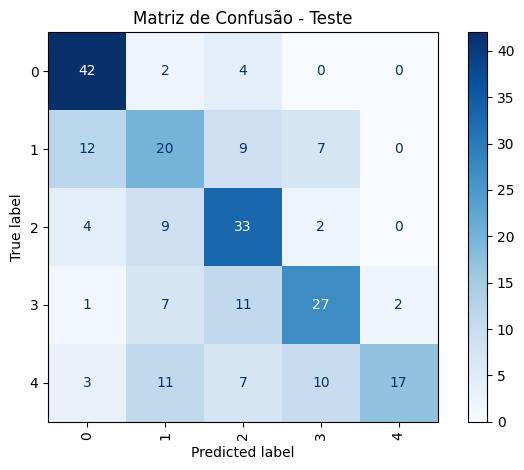

              precision    recall  f1-score   support

           0       0.68      0.88      0.76        48
           1       0.41      0.42      0.41        48
           2       0.52      0.69      0.59        48
           3       0.59      0.56      0.57        48
           4       0.89      0.35      0.51        48

    accuracy                           0.58       240
   macro avg       0.62      0.58      0.57       240
weighted avg       0.62      0.58      0.57       240



In [21]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = False, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)

## MLP

### Tratamento de Dados

In [23]:
# Inicializa o SMOTE transformer
smote_transformer = SmoteTransformer(random_state=42)

# Aplica SMOTE
X, y = smote_transformer.fit_transform(X, y)

# Mostra as dimensões após SMOTE
print("\nTamanho do conjunto após SMOTE:", X.shape)
print("Tamanho dos rótulos  após SMOTE:", y.shape)


Tamanho do conjunto após SMOTE: (800, 13)
Tamanho dos rótulos  após SMOTE: (800, 1)


In [24]:
X_processed, y_encoded, le = preprocess_data_standart_scale(X, y, categorical_cols, numeric_cols)
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (560, 13)
Tamanho do conjunto de teste: (240, 13)
Tamanho dos rótulos de treino: (560,)
Tamanho dos rótulos de teste: (240,)

Exemplo de X_train (primeiras 5 linhas):
          age       sex        cp  trestbps      chol       fbs   restecg  \
553 -0.112538 -1.437057 -0.440700 -0.086144  2.060813 -0.255434 -1.087998   
39   0.636678  0.695866 -0.440700  1.058199 -0.072192  3.914911 -1.087998   
754 -0.112538  0.695866 -0.440700 -0.721889 -0.275335 -0.255434  1.129577   
127 -1.486101  0.695866 -1.596636 -0.849039 -0.539422 -0.255434 -1.087998   
208 -2.235317  0.695866 -2.752571 -0.849039 -0.315964 -0.255434 -1.087998   

      thalach     exang   oldpeak     slope        ca      thal  
553 -0.370045 -0.656603 -0.422665 -1.275092  0.062327  0.559253  
39  -0.224358  1.522991 -0.468884  0.628031 -1.094451 -1.501214  
754  0.601202 -0.656603  0.851282  0.628031 -0.351738  0.845794  
127  1.378201 -0.656603 -1.332892 -1.275092 -1.094451 -1.501214  
208  1.96

### Métricas

In [25]:
random_search = busca_melhores_mlp(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

Melhores parâmetros encontrados: {'mlp__activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'mlp__dropout_rate': np.float64(0.13547045849996384), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (128, 64), 'mlp__learning_rate': np.float64(0.008966171489506599), 'mlp__max_epochs': 172, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.00376582952639944)}
Melhor acurácia: 0.7642857142857145
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       112
           1       0.83      0.77      0.80       112
           2       0.90      0.94      0.92       112
           3       0.90      0.93      0.92       112
           4       0.96      0.97      0.96       112

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



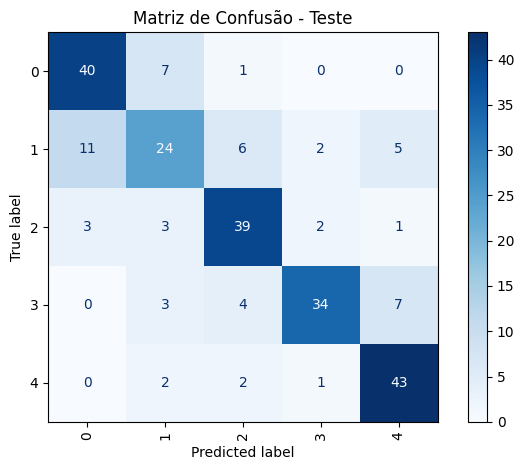

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        48
           1       0.62      0.50      0.55        48
           2       0.75      0.81      0.78        48
           3       0.87      0.71      0.78        48
           4       0.77      0.90      0.83        48

    accuracy                           0.75       240
   macro avg       0.75      0.75      0.74       240
weighted avg       0.75      0.75      0.74       240



In [26]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = False, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)